# Convolutional Neural Networks

Although it is possible to train a simple feedforward network to perform extremely well on a database such as MNIST, some substantial obstacles remain to its realistic use. This is because, despite its variety, the MNIST stimuli are still very carefully chosen. All the numbers are isolated, centered, and occupy roughly the same size. If any of these assumptions is violated, however, the network would fail.

Consider, for example, _scale_ invariance. All of the stimuli in MNIST database are carefully designed to take roughly the same amount of space on the image. But the size of handwriting also varies across individuals, with some writing in very large, and some others in very small, characters.  Once a network has learned how to respond to a large "7", it will likely not generalize to a small "7". Another problem is _translational_ invariance. The MNIST digits are all nicely centered in the middle of their matrices. Finally, in the most complicated case of object recognition, we have the problem of _viewpoint_ invariance: We can recognize a object, like a chair or cup, when presented from almost any point of view, including unusual ones.

These limitations do not violate Cybenko's theorem. As we noted before, Cybenko's theorem does not state how a network could be trained to approximate any function. In the limit, approximating the function might require training the network for an inconceivably long amount of time over all of the possible examples of this function.  Such a large example, however, is both unfeasible and directly in contrast with the most prized feature of a neural network---the ability to learn and generalize.   

Thus, what we really need is a network that can generalize robustly from a limited set of stimuli, and can learn to transfer what it has learned to new and different stimuli. It is the search of this robust generalizability that has spawned the field of machine learning known as "deep learning". In the case of visual stimuli, the solution came in the form of a particular feedforward network architecture known as _convolutional_ neural networ or CNN.    

Convolutional neural networks differ from the simple networks we have seen so far in three fundamental aspects. The first is the use of neurons with a specific type of activation function, known as Rectifier Linear Units or ReLUs. The second is the use of _convolutional_ layers, that is, layers in which all neurons share the same weights.  And the last one is the use of multiple hidden layers. It is the use of multiple hidden layers that has originated the name _deep_ learning, since the depth at which a layer can be nexted is much larger than in the traditional feedforward networks.
In the next section, we will review these building blocks.  

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

## Rectifier Linear Units

The first ingredient of CNNs (and, in fact, in most modern neural networks) is the use of a particular form of activation function known as the Rectifier Linear Unit, or ReLU .  A ReLU unit responds only if its summed input is greater than zero. If that is the case, the unit simply returns its summed input, otherwise, it returns zero:

\begin{equation*}
    y =
    \begin{cases}
    \sum_i x_i, & \textrm{if }  \sum_i x_i  > 0 \\
    0, & \textrm{if }  \sum_i x_i \leq 0
    \end{cases}
    \label{eq:nn:relu}
\end{equation*}

As usual, the threshold $\theta$ is ignored and we will assume that a bias unit is automatically added to the unit's inputs.

ReLUs offer many advantages. First, although the ReLU function is non-linear, its positive part is a simple linear function, which greatly simplifies all computations. Second, because they are silent (i.e., $ y = 0$) for all values that do not exceed the threshold, networks with ReLUs are naturally sparse, with only few neurons being active at any given time. Imagine a network that is initially set up with small random synaptic values: Statistically, it is expected that about half of the neurons would received small negative inputs. As a result, about half of the units would be silent. This makes it easier to sparsify the representations. Among the disadvantages of ReLUs is the fact that their activation function is discontinuous and, therefore, non-differentiable. Because of this, some researchers prefer to use the softplus function $y = \log \left( 1 / (1+e^x) \right)$. Most modelers, however, simply split the ReLU into two differentiable parts, the linear part when its inputs are $x > 0$ (and whose derivative is $dy/dx = 1$) and the constant part where the inputs are $x < 0$ (and whose derivative is $dy/dx = 0$). 


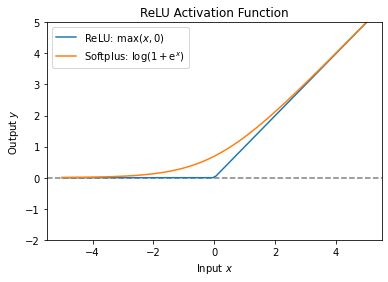

In [4]:
def relu(x):
    """Rectifier Linear Unit activation function"""
    if x > 0.0: return x
    else: return 0

def softplus(x):
    return np.log(1 + np.exp(x))
    
vrelu = np.vectorize(relu, otypes="f")
x = np.linspace(-5, 5, 100)
y = vrelu(x)
y2 = softplus(x)
plt.ylim(-2, 5)
plt.axhline(0, color="grey", linestyle="dashed", label="_nolegend_")
plt.plot(x, y, "-")
plt.plot(x, y2)
plt.legend(["ReLU: $\max(x, 0)$", "Softplus: $\log(1 + \mathrm{e}^{x})$"])
plt.title("ReLU Activation Function")
plt.xlabel("Input $x$")
plt.ylabel("Output $y$")
plt.savefig("figures/relu.png")
plt.show()

## Convolutional Layers

In the hidden layers of traditional, feedforward neural networks, every neuron is connected to all the other neurons of the layer below. Neurons of the convolutional layers, instead, are connected to only a limited portion of their input layer. This portion depends on the position of the neuron in the hidden layer. You can imagine that each convolutional neuron only "sees" a portion of its input layer, and that portion being seen changes, much like a point of view, as a function of where the neuron is located in hidden layer.   This means that the synapses between the convolutional layer and its input layer are topologically organized.

To understand how convolutional layers work, let's consider a hypothetical CNN network. The input layer of our network is  a $8 \times 8$ matrix. The convolutional layer is a $6 \times 6$ matrix. Instead of being connected to each unit in the input layer, units in the hidden layer are connected only to a subset of nine units, organized in a $3 \times 3$ square.  These connections are topologically organized, so that different units in the convolutional layer receive inputs from a corresponding different subset of units in the input layer. 

The set of input neurons that project to the same convolution neuron (that is, the input neurons that the convolutional neuron can "see") are called the convolutional neuron's {\it receptive field}. Receptive fields are typically overlapping. In most convolutional networks, receptive fields have the same shape as the input layer and cover it regularly and uniformly; the number of neurons that do not overlap between the receptive fields of adjacent neurons is called the {\it stride}. For example, here we will consider receptive fields with dimensions of $3 \times 3$ and a stride of 1. 

In addition to having a limited and partially overlapping receptive field, units in a convolutional layer have another characteristic: All of their input synapses have {\it exactly} the same weights. This means that the same synaptic matrix is uniformly applied through the input layer. In mathematics, the operation of applying the same matrix of weights at every position of an input matrix is called {\it convolution}, and the weight matrix itself is called the {\it kernel}.   

To understand how these properties become helpful, let us consider first how the weights of the receptive fields work. As we have seen before, the synaptic matrix of a neuron acts as a feature-detection system, designed to maximize the input of a neuron when a particular feature (or combination thereof) is present. For simplicity, we will examine an ideal case in which the features to detect are hardwired by the programmer. For example, if we want to detect the presence of a diagonal line in the input, we could handcraft a set of $3\times 3$ weights like this:

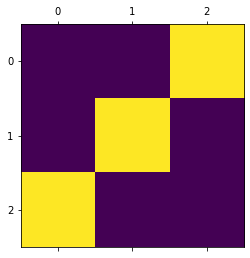

In [5]:
# kernel

k = -1*np.zeros((3,3))
k[2,0] = 1
k[1,1] = 1
k[0,2] = 1
plt.matshow(k, origin="upper")
plt.show()

The weight matrix above is the kernel and, because of the properties of the convolutional layer, it is applied everywhere in the input layer. Thus, a convolutional layer using this kernel acts a detector for any diagonal line anywhere in the input layer. It might be clear, by now, how this mechanism solves the translational invariance problems. For example, when presented with an 8x8 input which contains a diagnonal feature:

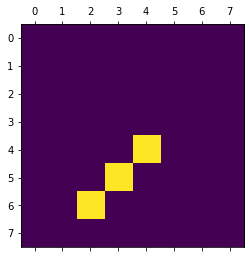

In [6]:
x = np.zeros((8,8))
x[6,2] = 1
x[5,3] = 1
x[4,4] = 1
plt.matshow(x, origin="upper")
plt.show()

The convolutional layer would correctly detect where the feature is located, and which position contains the most of this feature.

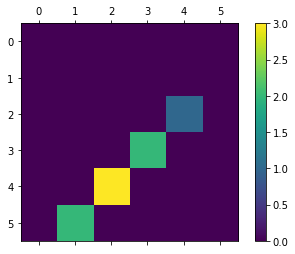

In [7]:
c = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rfield = x[i:(i+3),j:(j+3)]
        ii = rfield * k
        z = np.sum(ii)
        c[i,j] = relu(z)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(c, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

Now we can apply this kernel to a more naturalistic image: a hand-written "7"

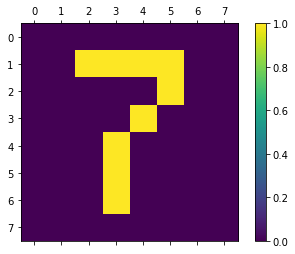

In [8]:
num = np.loadtxt("7_8x8.txt")
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(num, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

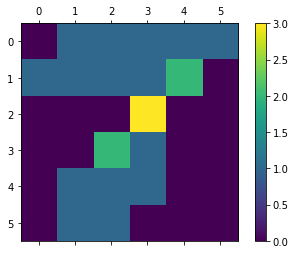

In [9]:
c = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rfield = num[i:(i+3),j:(j+3)]
        ii = rfield * k
        z = np.sum(ii)
        c[i,j] = relu(z)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(c, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

### Multiple Convolutional Layers

One convolutional layer, of course, would not be particularly useful. CNNs typically employ a variety of different convolutional layers, all with different kernels, applied to the same input layer, as shown below. Thus, unlike traditional networks where only one layer of neurons exists at any level, a CNN might have a "stack" of layers at the same level of the hierarchy.

For example, we might want to introduce a second convolutional layer designed to capture a horizontal line, and maybe a third layer designed to capture a vertical line. 

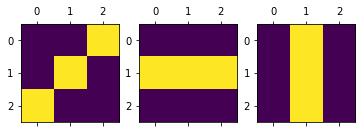

In [10]:
k1 = k

k2 = np.zeros((3,3))
k2[1,0] = 1
k2[1,1] = 1
k2[1,2] = 1

k3 = np.zeros((3,3))
k3[0,1] = 1
k3[1,1] = 1
k3[2,1] = 1

fig, axs = plt.subplots(1, 3)
for i, k in enumerate([k1, k2, k3]):
    axs[i].matshow(k, origin="upper")

The figures below provide an example of how this might work in the case of a simple CNN designed to recognize hand-written digits. In the figures, the input matrix of a "7" is fed through three convolutional layers with specific kernels. The bottom row of the figure depicts the resulting state of the convolutional layers associated with each kernel.  Each layer has one neuron that is maximally active in correspondence to the location of the corresponding figure in the input image. So, for example, diagonal line is in the middle, the horizontal line is on top, and the vertical line is in the bottom.

At this point, it should be clear how a CNN could be learn to recognize a handwritten digit. In the next layer of the hierarchy, a second set of convolutional layers would take inputs from receptive fields that occupy the same same position in all three convolutational layers, and could therefore detect the occurrenace of a horizontal line on top of a diagonal line on top of a vertical line--the building blocks of a "7".

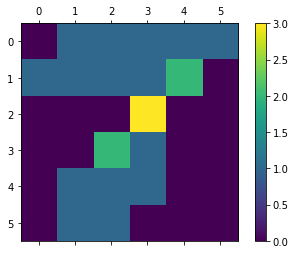

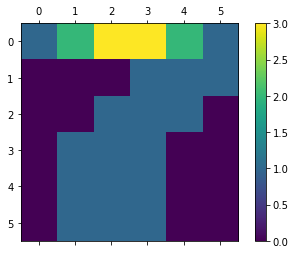

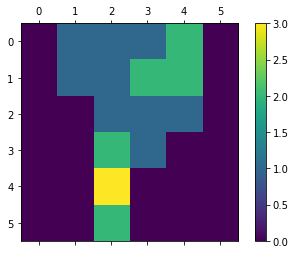

In [11]:

kernels = [k1, k2, k3]
clayers = [np.zeros((6,6)) for x in kernels]

for k, c in zip(kernels, clayers):
    for i in range(6):
        for j in range(6):
            rfield = num[i:(i+3),j:(j+3)]
            ii = rfield * k
            z = np.sum(ii)
            c[i,j] = relu(z)
            
for c in clayers:
    fig = plt.figure()
    ax = fig.add_subplot()
    cax = ax.matshow(c, interpolation='nearest', origin="upper")
    fig.colorbar(cax)
plt.show()

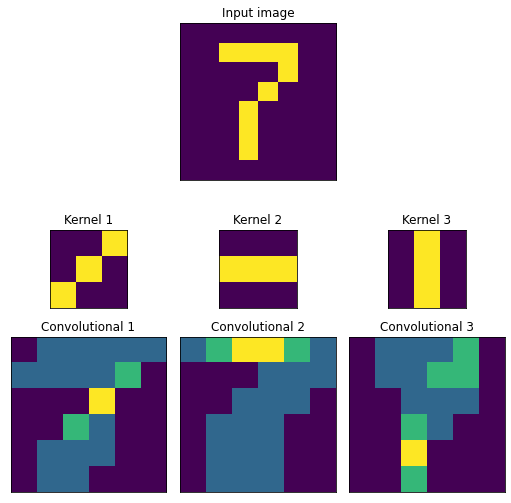

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(7,7))

spec = gs.GridSpec(3, 3, width_ratios=(1,1,1), height_ratios=(8,3,6), figure=fig)

ax = fig.add_subplot(spec[0, 1])
ax.matshow(num, interpolation='nearest', origin="upper")
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_title("Input image")

for i, k in enumerate(kernels):
    ax = fig.add_subplot(spec[1, i])
    ax.matshow(k, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Kernel %d" % (i+1))
    #fig.colorbar(cax)

for i, c in enumerate(clayers):
    ax = fig.add_subplot(spec[2, i])
    ax.matshow(c, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Convolutional %d" % (i+1))

plt.savefig("figures/multiple_conv_layers.png")

## Subsampling (Maxpooling) Layers

A CNN is made of a hierarchy of convolutional layers at different layers,  which deeper convolutional layers stacked upon each other.  At each layer, the convolutional layers abstract increasingly abstract features.  However, convolutional layers are typocally not just fed into each other. The typical architecture of a CNN includes a set of layers that are sandwiched between two consecutive convolutional layers in the hierarchy.   

These layers are called subsampling layers, also known as _maxpooling_ layers. Like convolutional layers, subsampling layers are topologically organized, with each neuron have a receptive field that covers only part of its input layer, and neighboring units having receptive fields that cover neighboring areas. Unlike convolutional layers, the receptive fields of subsampling layers do not overlap, and instead tesselate the input layer evenly. 


Most importantly, the receptive fields do not contain a kernel set of weights; instead, each output unit simply reflects the value of the most active input neuron in its receptive field---hence the name "maxpooling".

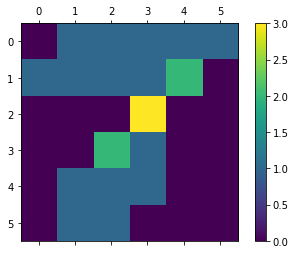

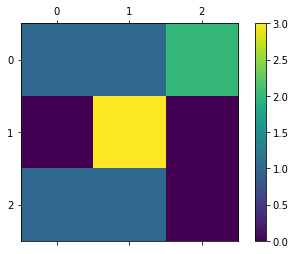

[[1. 1. 2.]
 [0. 3. 0.]
 [1. 1. 0.]]


In [17]:
def maxpool(x):
    """Maxpooling function -- max value of array of numbers"""
    return np.max(x)
    
# A maxpooling with a receptive field of 2x2

conv = clayers[0]  # Input to maxpooling is convolutional layer

mp = np.zeros((3,3)) # Mapooling matrix

for i in range(3):
    for j in range(3):
        rfield = conv[(i*2):(i*2) + 2, (j*2):(j*2 ) + 2]
        mp[i,j] = maxpool(rfield)
        
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(conv, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(mp, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

/tmp/ipykernel_16440/3443721646.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(spec[2, i])


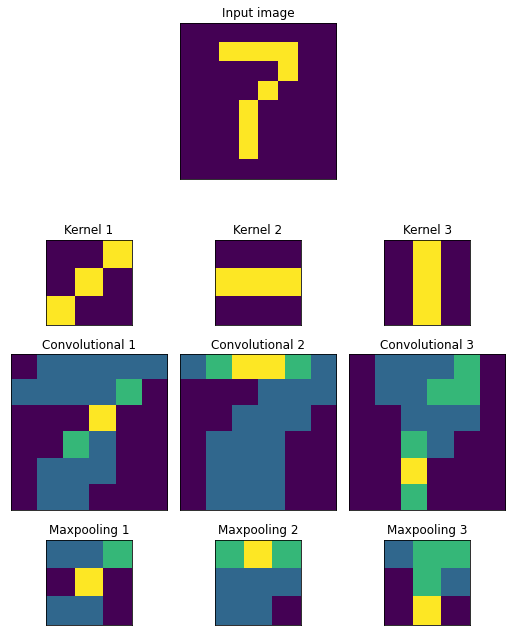

In [20]:
mps = [np.zeros((3,3)) for x in clayers]

for cl, mpl in zip(clayers, mps):
    for i in range(3):
        for j in range(3):
            rfield = cl[(i*2):(i*2) + 2, (j*2):(j*2 ) + 2]
            mpl[i,j] = maxpool(rfield)

fig = plt.figure(constrained_layout=True, figsize=(7,9))

spec = gs.GridSpec(4, 3, width_ratios=(1,1,1), height_ratios=(8,3,6,3), figure=fig)

ax = fig.add_subplot(spec[0, 1])
ax.matshow(num, interpolation='nearest', origin="upper")
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_title("Input image")

for i, k in enumerate(kernels):
    ax = fig.add_subplot(spec[1, i])
    ax.matshow(k, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Kernel %d" % (i+1))
    #fig.colorbar(cax)

for i, c in enumerate(clayers):
    ax = fig.add_subplot(spec[2, i])
    ax.matshow(c, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Convolutional %d" % (i+1))
    
for i, c in enumerate(clayers):
    ax = fig.add_subplot(spec[2, i])
    ax.matshow(c, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Convolutional %d" % (i+1))

for i, m in enumerate(mps):
    ax = fig.add_subplot(spec[3, i])
    ax.matshow(m, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Maxpooling %d" % (i+1))
plt.savefig("figures/multiple_conv_mp_layers.png")